In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style # for styling the graphs
# style.available (to know the available list of styles)
style.use('ggplot') # chosen style
plt.rc('xtick',labelsize=13) # to globally set the tick size
plt.rc('ytick',labelsize=13) # to globally set the tick size
# To print multiple outputs together
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Change column display number during print
pd.set_option('display.max_columns', 500)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# To display float with 2 decimal, avoid scientific printing
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor ,RandomForestRegressor
from xgboost import XGBRegressor 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error,accuracy_score,mean_squared_log_error,r2_score
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

In [161]:
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [162]:
print(df.shape)
print(test.shape)

(34226, 16)
(14669, 15)


In [163]:
df.set_index('id',inplace = True)

df['last_review'] = pd.to_datetime(df['last_review'])
df['month'] = pd.DatetimeIndex(df['last_review']).month
df['year'] = pd.DatetimeIndex(df['last_review']).year

df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].median())
df['year'] = df['year'].fillna(df['year'].mode()[0])
df['month'] = df['month'].fillna(df['month'].mode()[0])

df.loc[df.availability_365 == 0, 'availability_365'] = df.availability_365.median()
df.loc[df.number_of_reviews == 0, 'number_of_reviews'] = df.number_of_reviews.median()
df.loc[df.price == 0, 'price'] = df.price.median()

df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)
df['number_of_reviews'] = df['number_of_reviews'].astype(int)
df['price'] = df['price'].astype(int)
df['availability_365'] = df['availability_365'].astype(int)

In [164]:
test.set_index('id',inplace = True)

test['last_review'] = pd.to_datetime(test['last_review'])
test['month'] = pd.DatetimeIndex(test['last_review']).month
test['year'] = pd.DatetimeIndex(test['last_review']).year

test['reviews_per_month'] = test['reviews_per_month'].fillna(test['reviews_per_month'].median())
test['year'] = test['year'].fillna(test['year'].mode()[0])
test['month'] = test['month'].fillna(test['month'].mode()[0])

test.loc[test.availability_365 == 0, 'availability_365'] = test.availability_365.median()
test.loc[test.number_of_reviews == 0, 'number_of_reviews'] = test.number_of_reviews.median()
#test.loc[test.price == 0, 'price'] = test.price.median()

test['month'] = test['month'].astype(int)
test['year'] = test['year'].astype(int)
test['number_of_reviews'] = test['number_of_reviews'].astype(int)
#test['price'] = test['price'].astype(int)
test['availability_365'] = test['availability_365'].astype(int)

In [165]:
df.drop(['name','host_name','last_review','host_id','neighbourhood','month','year'],axis = 1,inplace=True)
test.drop(['name','host_name','last_review','host_id','neighbourhood','month','year'],axis = 1,inplace=True)

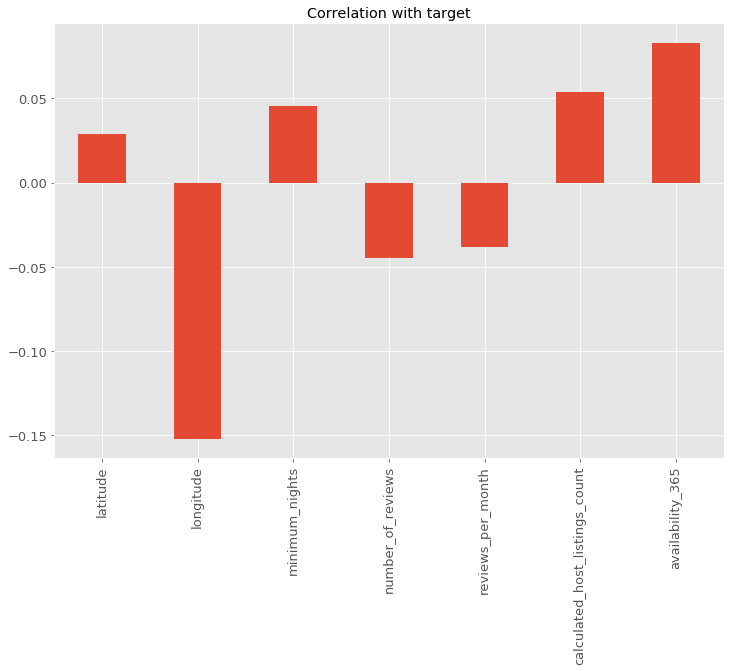

In [166]:
df.drop('price', axis=1).corrwith(df.price).plot(kind='bar', grid=True, figsize=(12, 8), 
                                                   title="Correlation with target")

In [167]:
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns=['Feature','Number of Outliers'])
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            # first quartile (Q1)
            q1 = dataframe[column].quantile(0.25) 
            
            # third quartile (Q3)
            q3 = dataframe[column].quantile(0.75)
            
            # IQR
            iqr = q3 - q1
            
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column,'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(df)
detect_outliers(test)

,Feature,Number of Outliers
0,latitude,301
1,longitude,1965
2,price,2114
3,minimum_nights,4581
4,number_of_reviews,4557
5,reviews_per_month,2765
6,calculated_host_listings_count,4930
7,availability_365,0


,Feature,Number of Outliers
0,latitude,119
1,longitude,863
2,minimum_nights,2026
3,number_of_reviews,1974
4,reviews_per_month,1307
5,calculated_host_listings_count,2151
6,availability_365,0


In [168]:
df.skew()

latitude                          0.24
longitude                         1.28
price                            18.82
minimum_nights                   24.00
number_of_reviews                 3.72
reviews_per_month                 3.98
calculated_host_listings_count    7.97
availability_365                  0.86
dtype: float64

In [169]:
#df['month'] = winsorize(df['month'] , limits=[0.05, 0.1],inclusive=(True, True))
#df['year'] = winsorize(df['year'] , limits=[0.05, 0.1],inclusive=(True, True))
df['number_of_reviews'] = winsorize(df['number_of_reviews'] , limits=[0.05, 0.1],inclusive=(True, True))
df['reviews_per_month'] = winsorize(df['reviews_per_month'] , limits=[0.05, 0.1],inclusive=(True, True))
df['minimum_nights'] = winsorize(df['minimum_nights'] , limits=[0.05, 0.1],inclusive=(True, True))
df['price'] = winsorize(df['price'] , limits=[0.05, 0.1],inclusive=(True, True))
df['calculated_host_listings_count']=winsorize(df['calculated_host_listings_count'] , limits=[0.05, 0.1],inclusive=(True, True))
df['latitude']= winsorize(df['latitude'] , limits=[0.05, 0.1],inclusive=(True, True))
df['longitude']= winsorize(df['longitude'] , limits=[0.05, 0.1],inclusive=(True, True))

In [170]:
#test['month'] = winsorize(test['month'] , limits=[0.05, 0.1],inclusive=(True, True))
#test['year'] = winsorize(test['year'] , limits=[0.05, 0.1],inclusive=(True, True))
test['number_of_reviews'] = winsorize(test['number_of_reviews'] , limits=[0.05, 0.1],inclusive=(True, True))
test['reviews_per_month'] = winsorize(test['reviews_per_month'] , limits=[0.05, 0.1],inclusive=(True, True))
test['minimum_nights'] = winsorize(test['minimum_nights'] , limits=[0.05, 0.1],inclusive=(True, True))
#test['price'] = winsorize(test['price'] , limits=[0.05, 0.1],inclusive=(True, True))
test['calculated_host_listings_count']=winsorize(test['calculated_host_listings_count'] , limits=[0.05, 0.1],inclusive=(True, True))
test['latitude']= winsorize(test['latitude'] , limits=[0.05, 0.1],inclusive=(True, True))
test['longitude']= winsorize(test['longitude'] , limits=[0.05, 0.1],inclusive=(True, True))

In [171]:
detect_outliers(df)
detect_outliers(test)

,Feature,Number of Outliers
0,latitude,0
1,longitude,0
2,price,0
3,minimum_nights,4581
4,number_of_reviews,4557
5,reviews_per_month,0
6,calculated_host_listings_count,4930
7,availability_365,0


,Feature,Number of Outliers
0,latitude,0
1,longitude,0
2,minimum_nights,2026
3,number_of_reviews,1974
4,reviews_per_month,0
5,calculated_host_listings_count,2151
6,availability_365,0


In [172]:
df['number_of_reviews']= np.log1p(df['number_of_reviews'])
test['number_of_reviews'] = np.log1p(test['number_of_reviews'])
df['minimum_nights']= np.log1p(df['minimum_nights'])
test['minimum_nights']= np.log1p(test['minimum_nights'])

In [173]:
detect_outliers(df)
detect_outliers(test)

,Feature,Number of Outliers
0,latitude,0
1,longitude,0
2,price,0
3,minimum_nights,0
4,number_of_reviews,0
5,reviews_per_month,0
6,calculated_host_listings_count,4930
7,availability_365,0


,Feature,Number of Outliers
0,latitude,0
1,longitude,0
2,minimum_nights,0
3,number_of_reviews,0
4,reviews_per_month,0
5,calculated_host_listings_count,2151
6,availability_365,0


In [144]:
X=df.drop('price',axis=1)
y=df.price
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [145]:
label_encode_cols = ['neighbourhood_group','room_type']

In [146]:
print(X_test.shape)
print(y_test.shape)
print(test.shape)

(10268, 9)
(10268,)
(14669, 9)


In [51]:
for col in label_encode_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    test[col]= le.transform(test[col])

In [52]:
X_train.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,
8881955,1,40.67,-73.96,1,1.10,0.69,0.05,1,45
18612976,1,40.66,-73.91,1,1.95,3.30,1.00,3,90
18763188,2,40.80,-73.97,0,1.39,1.39,0.27,1,45
36312899,3,40.69,-73.91,0,1.10,1.79,0.73,1,62
13980280,1,40.68,-73.97,0,2.40,1.79,0.73,1,45


In [53]:
test.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,
1525602,1,40.67,-73.96,0,1.10,4.26,1.70,1,39
30430185,2,40.76,-74.00,1,0.69,2.94,2.49,6,364
21354525,1,40.69,-73.99,1,0.69,4.26,3.21,1,108
35995074,3,40.77,-73.91,1,2.30,1.79,0.70,2,365
34392081,1,40.72,-73.95,1,0.69,3.37,3.21,2,20


In [55]:
df.neighbourhood_group.value_counts()

Manhattan        15193
Brooklyn         14033
Queens            3985
Bronx              767
Staten Island      248
Name: neighbourhood_group, dtype: int64

In [56]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
y_pred=model.predict(X_test)
y_pred_train = model.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(y_train,y_pred_train))
rmse_test=np.sqrt(mean_squared_error(y_test,y_pred))
print(rmse_train)
print(rmse_test)

51.58545401715558
51.96521413349933


In [58]:
print('Test Score :', model.score(X_test,y_test))

Test Score : 0.48538219278775213


In [59]:
print('Train Score :',model.score(X_train,y_train))

Train Score : 0.49584775179343255


### Test Data

In [87]:
y_pred_test = model.predict(test)

In [88]:
submission_1 =pd.DataFrame(y_pred_test,index=test.index,columns=['price'])

In [89]:
submission_1.to_csv('submission_1.csv')

## `Decision Tree Regressor`

In [72]:
model = DecisionTreeRegressor(max_depth=3,random_state=17)
model.fit(X_train, y_train)
y_dt = model.predict(X_test)
y_dt_train = model.predict(X_train)
print('RMSE Value Train is ',np.sqrt(mean_squared_error(y_train, y_dt_train)))
print('RMSE Value Test is ',np.sqrt(mean_squared_error(y_test, y_dt)))
y_pred_test = model.predict(test)
sample_submission_2 =pd.DataFrame(y_pred_test,columns = ['price'],index= test.index)
sample_submission_2.to_csv('submission_2.csv')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=17, splitter='best')

RMSE Value Train is  51.500401459145294
RMSE Value Test is  51.74692492674651


In [73]:
print('Train Score :',model.score(X_train,y_train))
print('Test Score :', model.score(X_test,y_test))

Train Score : 0.49750884366451875
Test Score : 0.4896966008796479


## `Random Tree Regressor`

In [74]:
model = RandomForestRegressor(max_depth=3,random_state=0)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
y_rf_train = model.predict(X_train)
print('RMSE Value Train is ',np.sqrt(mean_squared_error(y_train, y_rf_train)))
print('RMSE Value Test is ',np.sqrt(mean_squared_error(y_test, y_pred_rf)))
y_pred_test_rf = model.predict(test)
sample_submission3 =pd.DataFrame(y_pred_test_rf,columns = ['price'],index= test.index)
sample_submission3.to_csv('submission_3.csv')

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

RMSE Value Train is  51.18240464186699
RMSE Value Test is  51.49541269574016


In [75]:
print('Train Score :',model.score(X_train,y_train))
print('Test Score :', model.score(X_test,y_test))

Train Score : 0.5036950969225653
Test Score : 0.4946451320066685


## Scaling

In [175]:
test.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,
1525602,Brooklyn,40.67,-73.96,Entire home/apt,1.10,4.26,1.70,1,39
30430185,Manhattan,40.76,-74.00,Private room,0.69,2.94,2.49,6,364
21354525,Brooklyn,40.69,-73.99,Private room,0.69,4.26,3.21,1,108
35995074,Queens,40.77,-73.91,Private room,2.30,1.79,0.70,2,365
34392081,Brooklyn,40.72,-73.95,Private room,0.69,3.37,3.21,2,20


In [174]:
X=df.drop('price',axis=1)
y=df.price

In [176]:
test_cols = test.columns
X_cols = X.columns

In [177]:
le = LabelEncoder()
for col in label_encode_cols:
    X[col] = le.fit_transform(X[col])
    test[col] = le.transform(test[col])
    
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.fit_transform(test)
X = pd.DataFrame(X_scaled, columns=X_cols,index =X.index)
test = pd.DataFrame(test_scaled, columns =test_cols,index = test.index )

# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=72)

## `Linear Regression on Scaled Data`

In [178]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print('Train RMSE:',np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test, lr.predict(X_test))));

Train RMSE: 51.70959600995507
Test RMSE: 51.65532208583279


In [179]:
target_scaler = StandardScaler()

In [181]:
y_pred_test_linear = lr.predict(test)
sample_submission4 =pd.DataFrame(y_pred_test_linear,columns = ['price'],index= test.index)
sample_submission4.to_csv('submission_4.csv')

In [182]:
y_pred_test_linear

array([141.91822478, 159.69088391, 107.9613316 , ..., 118.80179748,
       196.36335985, 133.19112112])

In [183]:
print('Train Score :',lr.score(X_train,y_train))
print('Test Score :', lr.score(X_test,y_test))

Train Score : 0.49411440129976947
Test Score : 0.4887161332549469


## `Decision tree on Scaled Data`

In [184]:
dt_reg = DecisionTreeRegressor(random_state=42)

param_grid = dict(max_depth=range(5,20), min_samples_split=range(50,200,10), min_samples_leaf=range(25,100,10), max_leaf_nodes=range(8,32,2), min_impurity_decrease=(0.3,1.0,0.1))
grid = RandomizedSearchCV(dt_reg, param_grid, scoring='neg_mean_squared_error', n_jobs=4, cv=5, random_state=33)
grid.fit(X_train,y_train);


print('Train RMSLE:',np.sqrt(mean_squared_error(y_train, grid.best_estimator_.predict(X_train))))
print('Test RMSLE:',np.sqrt(mean_squared_error(y_test, grid.best_estimator_.predict(X_test))));

Train RMSLE: 48.89972575305466
Test RMSLE: 49.471447383774


In [185]:
dt_best =grid.best_estimator_

In [186]:
print('Train Score :',dt_best.score(X_train,y_train))
print('Test Score :', dt_best.score(X_test,y_test))

Train Score : 0.5475997110481974
Test Score : 0.5310341974077308


In [187]:
y_pred_test_dt = dt_best.predict(test)
sample_submission5 =pd.DataFrame(y_pred_test_dt,columns = ['price'],index= test.index)
sample_submission5.to_csv('submission_5.csv')

## `Random Forest on Scaled Data`

In [188]:
rf_model = RandomForestRegressor(random_state=33)
param_grid = dict(n_estimators=range(10,100,10),max_depth=range(3,20),min_samples_split=range(50,500,20),min_samples_leaf=range(25,75,10),max_leaf_nodes=range(8,32,2))
grid = RandomizedSearchCV(rf_model,param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,random_state=33)
grid.fit(X_train,y_train);


print('Train RMSLE:',np.sqrt(mean_squared_error(y_train, grid.best_estimator_.predict(X_train))))
print('Test RMSLE:',np.sqrt(mean_squared_error(y_test, grid.best_estimator_.predict(X_test))));

Train RMSLE: 48.27076825197224
Test RMSLE: 48.6207729166086


In [189]:
rf_best = grid.best_estimator_

In [190]:
print('Train Score :',rf_best.score(X_train,y_train))
print('Test Score :', rf_best.score(X_test,y_test))

Train Score : 0.5591625835884486
Test Score : 0.5470235140803635


In [191]:
y_pred_test_rf = rf_best.predict(test)
sample_submission6 =pd.DataFrame(y_pred_test_rf,columns = ['price'],index= test.index)
sample_submission6.to_csv('submission_6.csv')